## Домашнее задание 1
### Пункт 1
> Выбрать и загрузить датасет с помощью библиотеки Pandas. Датасет должен относиться к задаче классификации, содержать категориальные данные. Реализовать код, вносящий случайные искажения в данные.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel, SequentialFeatureSelector
from sklearn.metrics import accuracy_score

# https://www.kaggle.com/datasets/jsphyg/weather-dataset-rattle-package
df = pd.read_csv('weatherAUS.csv')

print("Размер датасета:", df.shape)
print("\nПервые 5 строк:")
df.head(5)

Размер датасета: (145460, 23)

Первые 5 строк:


,Date,Location,MinTemp,MaxTemp,Rainfall,Evaporation,Sunshine,WindGustDir,WindGustSpeed,WindDir9am,...,Humidity9am,Humidity3pm,Pressure9am,Pressure3pm,Cloud9am,Cloud3pm,Temp9am,Temp3pm,RainToday,RainTomorrow
0,2008-12-01,Albury,13.4,22.9,0.6,NaN,NaN,W,44.0,W,...,71.0,22.0,1007.7,1007.1,8.0,NaN,16.9,21.8,No,No
1,2008-12-02,Albury,7.4,25.1,0.0,NaN,NaN,WNW,44.0,NNW,...,44.0,25.0,1010.6,1007.8,NaN,NaN,17.2,24.3,No,No
2,2008-12-03,Albury,12.9,25.7,0.0,NaN,NaN,WSW,46.0,W,...,38.0,30.0,1007.6,1008.7,NaN,2.0,21.0,23.2,No,No
3,2008-12-04,Albury,9.2,28.0,0.0,NaN,NaN,NE,24.0,SE,...,45.0,16.0,1017.6,1012.8,NaN,NaN,18.1,26.5,No,No
4,2008-12-05,Albury,17.5,32.3,1.0,NaN,NaN,W,41.0,ENE,...,82.0,33.0,1010.8,1006.0,7.0,8.0,17.8,29.7,No,No


In [2]:
# Функция для внесения случайных искажений
def add_random_distortions(data, distortion_rate=0.05):
    distorted_data = data.copy()
    n_rows, n_cols = distorted_data.shape

    # 1. Добавление пропущенных значений
    for col in distorted_data.columns:
        if distorted_data[col].dtype in ['float64', 'int64']:
            mask = np.random.random(n_rows) < distortion_rate
            distorted_data.loc[mask, col] = np.nan

    # 2. Искажение категориальных данных
    categorical_cols = distorted_data.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        if col not in ['Date', 'Location']:  # Не искажаем дату и локацию
            mask = np.random.random(n_rows) < distortion_rate
            unique_vals = distorted_data[col].dropna().unique()
            if len(unique_vals) > 0:
                distorted_data.loc[mask, col] = np.random.choice(unique_vals, mask.sum())

    # 3. Добавление выбросов в числовые данные
    numerical_cols = distorted_data.select_dtypes(include=['float64', 'int64']).columns
    for col in numerical_cols:
        mask = np.random.random(n_rows) < distortion_rate * 0.5  # Меньше выбросов
        if mask.any():
            outliers = distorted_data[col].mean() + 5 * distorted_data[col].std() * np.random.randn(mask.sum())
            distorted_data.loc[mask, col] = outliers

    return distorted_data

# Применяем искажения
df_distorted = add_random_distortions(df)
print("Данные после искажений:")
print(f"Пропуски в исходных данных: {df.isnull().sum().sum()}")
print(f"Пропуски в искаженных данных: {df_distorted.isnull().sum().sum()}")

Данные после искажений:
Пропуски в исходных данных: 343248
Пропуски в искаженных данных: 431068


## Пункт 2
> С помощью библиотеки Pandas произвести предварительный анализ датасета на наличие пропусков и искажений. Произвести исправление данных, используя 3 различные стратегии.

In [3]:
# Анализ пропусков
print("Анализ пропусков в данных:")
missing_data = df_distorted.isnull().sum()
missing_percent = (missing_data / len(df_distorted)) * 100
missing_info = pd.DataFrame({
    'Колонка': df_distorted.columns,
    'Пропуски': missing_data,
    'Процент пропусков': missing_percent
})
print(missing_info[missing_info['Пропуски'] > 0].sort_values('Процент пропусков', ascending=False))

# Анализ типов данных
print("\nТипы данных:")
print(df_distorted.dtypes.value_counts())

Анализ пропусков в данных:
                     Колонка  Пропуски  Процент пропусков
Sunshine            Sunshine     71727          49.310463
Evaporation      Evaporation     65191          44.817132
Cloud3pm            Cloud3pm     61959          42.595215
Cloud9am            Cloud9am     58772          40.404235
Pressure9am      Pressure9am     21109          14.511893
Pressure3pm      Pressure3pm     20884          14.357212
WindGustSpeed  WindGustSpeed     16502          11.344700
Humidity3pm      Humidity3pm     11202           7.701086
Temp3pm              Temp3pm     10360           7.122233
Rainfall            Rainfall     10088           6.935240
WindDir9am        WindDir9am     10018           6.887117
WindSpeed3pm    WindSpeed3pm      9935           6.830056
WindGustDir      WindGustDir      9828           6.756497
Humidity9am      Humidity9am      9284           6.382511
WindSpeed9am    WindSpeed9am      8688           5.972776
Temp9am              Temp9am      8604       

In [4]:
# Стратегия 1: Удаление строк с большим количеством пропусков
df_strategy1 = df_distorted.dropna(subset=['RainToday', 'RainTomorrow']).copy()

# Стратегия 2: Альтернативный вариант (пошаговый и понятный)
df_strategy2 = df_distorted.copy()

numerical_cols = df_strategy2.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df_strategy2.select_dtypes(include=['object']).columns

# Заполняем числовые колонки
for col in numerical_cols:
    median_val = df_strategy2[col].median()
    df_strategy2[col] = df_strategy2[col].fillna(median_val)

# Заполняем категориальные колонки
for col in categorical_cols:
    if col != 'RainTomorrow':
        mode_val = df_strategy2[col].mode()
        fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
        df_strategy2[col] = df_strategy2[col].fillna(fill_val)

# Стратегия 3: Интерполяция для временных рядов (полностью исправленная)
df_strategy3 = df_distorted.copy()
df_strategy3['Date'] = pd.to_datetime(df_strategy3['Date'])
df_strategy3 = df_strategy3.sort_values(['Location', 'Date']).copy()

# Создаем копию для безопасной модификации
result_data = []

for location in df_strategy3['Location'].unique():
    location_data = df_strategy3[df_strategy3['Location'] == location].copy()

    # Интерполяция для числовых колонок
    for col in numerical_cols:
        location_data[col] = location_data[col].interpolate(method='linear')
        location_data[col] = location_data[col].bfill()

    result_data.append(location_data)

# Объединяем обратно
df_strategy3 = pd.concat(result_data, ignore_index=True)

# Заполняем категориальные колонки
for col in categorical_cols:
    if col not in ['Date', 'RainTomorrow']:
        mode_val = df_strategy3[col].mode()
        fill_val = mode_val[0] if len(mode_val) > 0 else 'Unknown'
        df_strategy3[col] = df_strategy3[col].fillna(fill_val)

print("Результаты обработки пропусков (исправленные):")
print(f"Стратегия 1 (удаление): {df_strategy1.shape}")
print(f"Стратегия 2 (медиана/мода): {df_strategy2.isnull().sum().sum()} пропусков осталось")
print(f"Стратегия 3 (интерполяция): {df_strategy3.isnull().sum().sum()} пропусков осталось")

Результаты обработки пропусков (исправленные):
Стратегия 1 (удаление): (140952, 23)
Стратегия 2 (медиана/мода): 3101 пропусков осталось
Стратегия 3 (интерполяция): 3101 пропусков осталось


## Пункт 3
> С помощью библиотеки matplotlib построить графики исходных данных для каждой пары признаков (если набор данных позволяет это, в противном случае вернуться к этому пункту после уменьшения размерности в п.6). Сделать выводы о зависимости признаков.

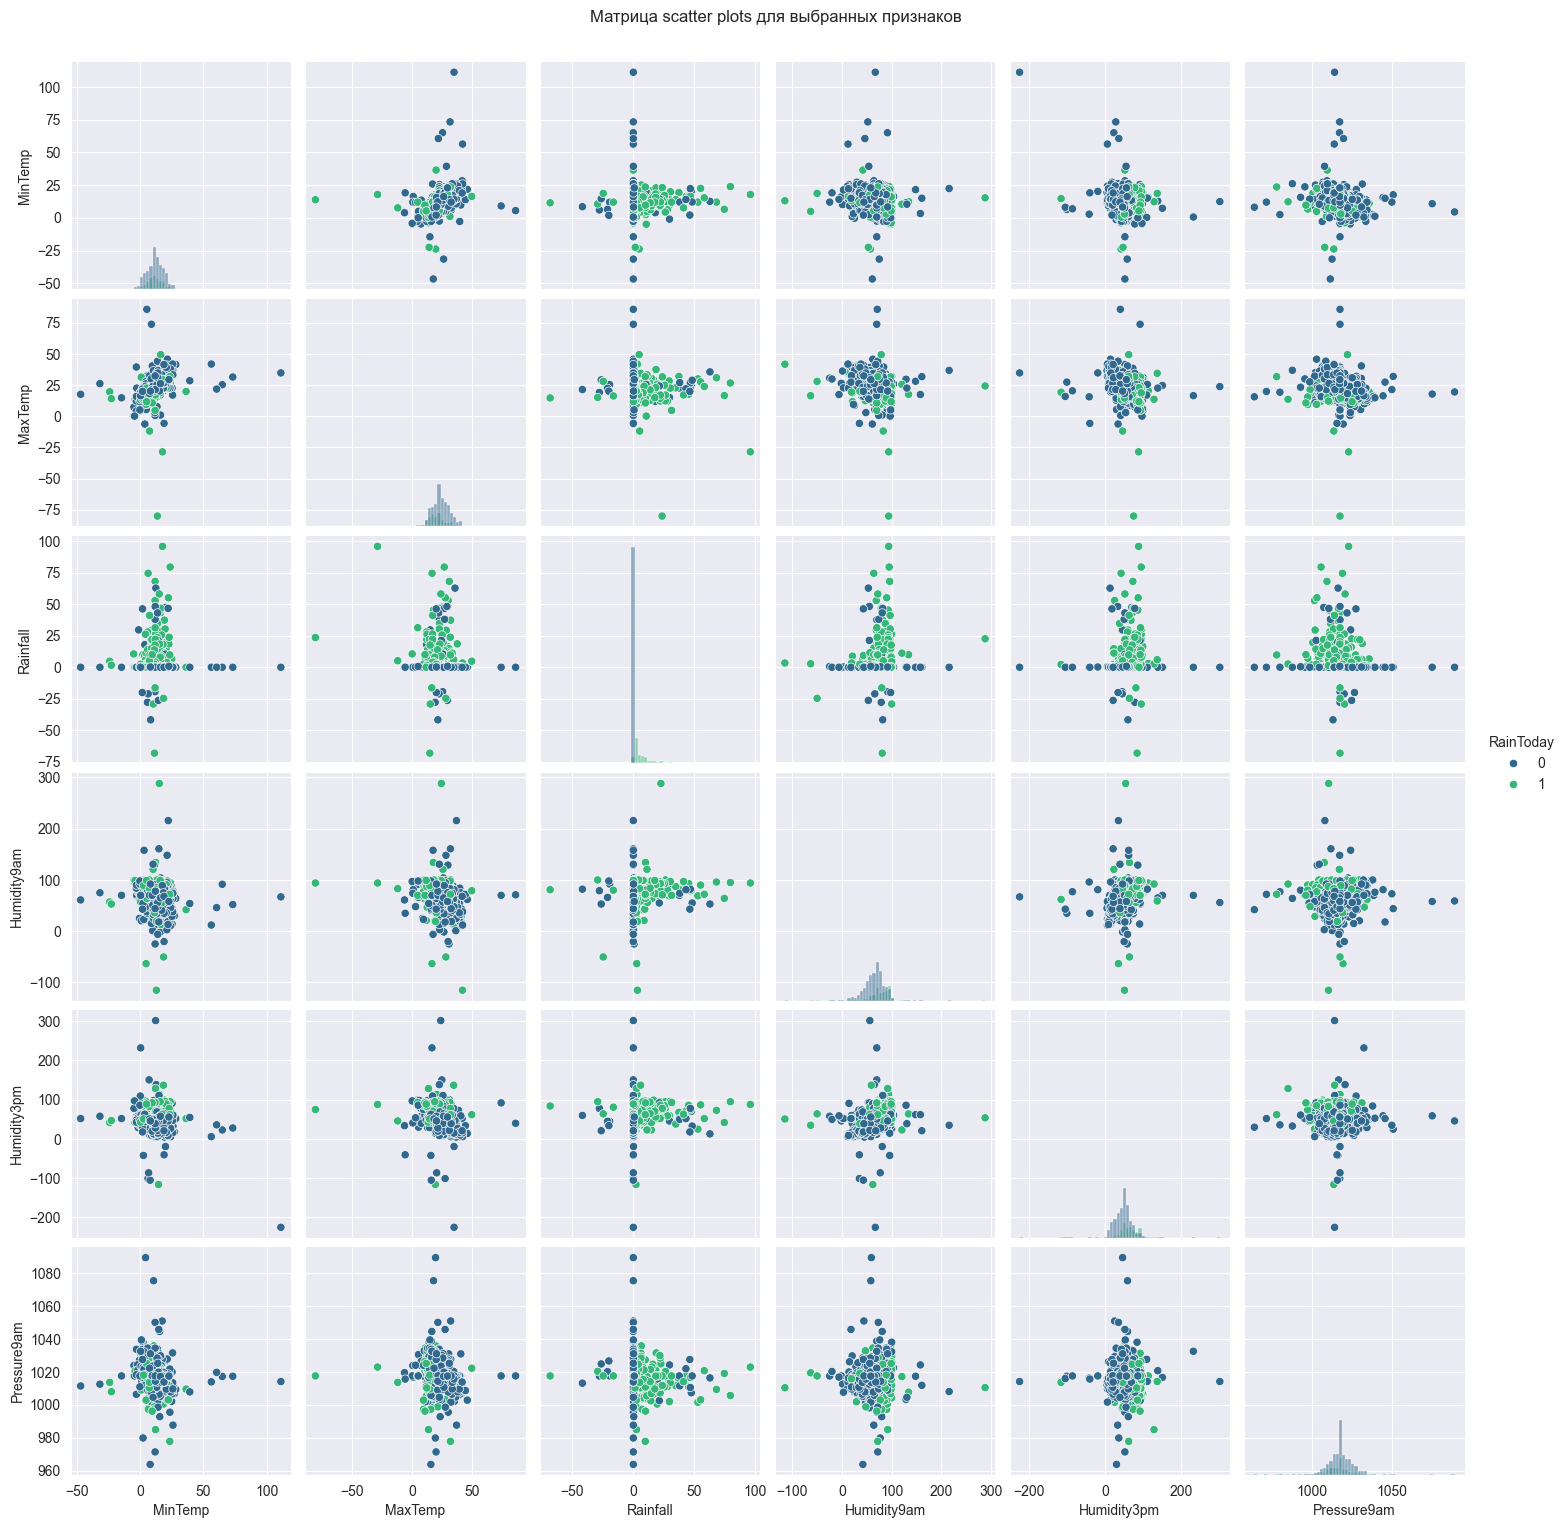

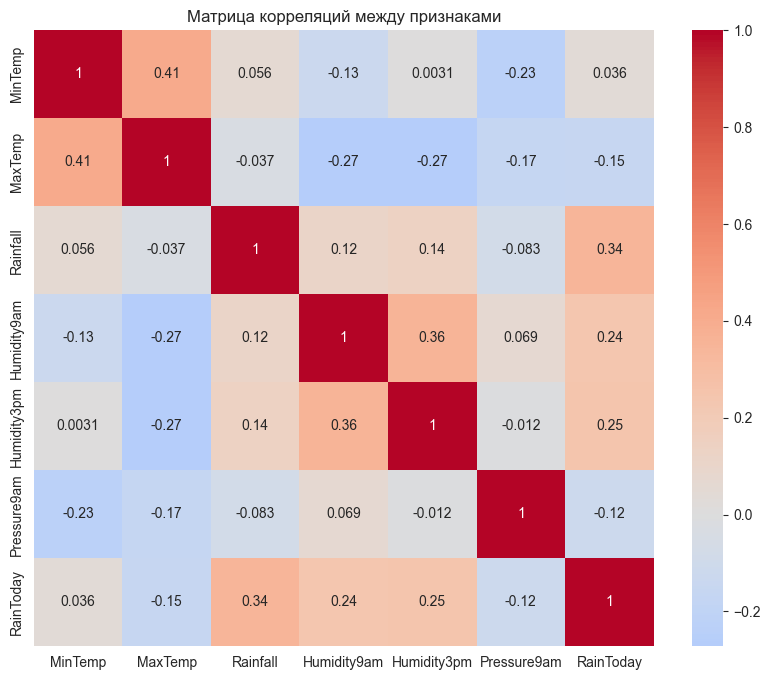

Выводы по визуализации:
1. Высокая корреляция между MinTemp и MaxTemp (ожидаемо)
2. Влажность (Humidity9am, Humidity3pm) показывает умеренную корреляцию с дождем
3. Давление имеет отрицательную корреляцию с вероятностью дождя
4. Из-за большого количества признаков полный анализ требует уменьшения размерности


In [5]:
# Выберем подмножество числовых признаков для визуализации
numerical_features = ['MinTemp', 'MaxTemp', 'Rainfall', 'Humidity9am', 'Humidity3pm', 'Pressure9am']
df_viz = df_strategy2[numerical_features + ['RainToday']].dropna()
df_viz['RainToday'] = df_viz['RainToday'].map({'Yes': 1, 'No': 0})

# Матрица scatter plots
sns.pairplot(df_viz.sample(1000), hue='RainToday', diag_kind='hist', palette='viridis')
plt.suptitle('Матрица scatter plots для выбранных признаков', y=1.02)
plt.show()

# Heatmap корреляций
plt.figure(figsize=(10, 8))
correlation_matrix = df_viz.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Матрица корреляций между признаками')
plt.show()

print("Выводы по визуализации:")
print("1. Высокая корреляция между MinTemp и MaxTemp (ожидаемо)")
print("2. Влажность (Humidity9am, Humidity3pm) показывает умеренную корреляцию с дождем")
print("3. Давление имеет отрицательную корреляцию с вероятностью дождя")
print("4. Из-за большого количества признаков полный анализ требует уменьшения размерности")

## Пункт 4
> Произвести кодирование категориальных признаков. Применить one-hot-encoding. Произвести стандартизацию данных.

In [6]:
# Используем стратегию 2 для дальнейшей работы
df_processed = df_strategy2.copy()

# Кодирование целевой переменной
df_processed['RainTomorrow'] = df_processed['RainTomorrow'].map({'Yes': 1, 'No': 0})
df_processed['RainToday'] = df_processed['RainToday'].map({'Yes': 1, 'No': 0})

# One-Hot Encoding для категориальных признаков
categorical_cols_to_encode = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm']
df_encoded = pd.get_dummies(df_processed, columns=categorical_cols_to_encode, drop_first=True)

# Удаляем колонку Date (не несет полезной информации без временного анализа)
if 'Date' in df_encoded.columns:
    df_encoded = df_encoded.drop('Date', axis=1)

print(f"Размерность после One-Hot Encoding: {df_encoded.shape}")

# Стандартизация числовых данных
numerical_cols = ['MinTemp', 'MaxTemp', 'Rainfall', 'Evaporation', 'Sunshine',
                  'WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm',
                  'Humidity9am', 'Humidity3pm', 'Pressure9am', 'Pressure3pm',
                  'Cloud9am', 'Cloud3pm', 'Temp9am', 'Temp3pm']

scaler = StandardScaler()
df_encoded[numerical_cols] = scaler.fit_transform(df_encoded[numerical_cols])

# Удаляем строки с пропущенной целевой переменной
df_final = df_encoded.dropna(subset=['RainTomorrow'])

print(f"Финальный размер датасета: {df_final.shape}")
print(f"Количество признаков: {df_final.shape[1] - 1}")  # -1 для целевой переменной

Размерность после One-Hot Encoding: (145460, 111)
Финальный размер датасета: (142359, 111)
Количество признаков: 110


## Пункт 5
> Разделить данные на обучающий и проверочный наборы. Решить задачу классификации, используя  библиотеку sklearn тремя способами (логистическая регрессия, метод опорных векторов, случайный лес), сравнить полученные результаты (метод score) для обучающих и проверочных данных. Сделать выводы.

Размер обучающей выборки: (9965, 110)
Размер тестовой выборки: (4271, 110)
Баланс классов в обучающей выборке: RainTomorrow
0.0    0.761064
1.0    0.238936
Name: proportion, dtype: float64
Logistic Regression:
  Обучающая выборка: 0.8099
  Тестовая выборка:  0.8026
  Разница: 0.0073
SVM:
  Обучающая выборка: 0.8537
  Тестовая выборка:  0.8134
  Разница: 0.0403
Random Forest:
  Обучающая выборка: 1.0000
  Тестовая выборка:  0.8125
  Разница: 0.1875


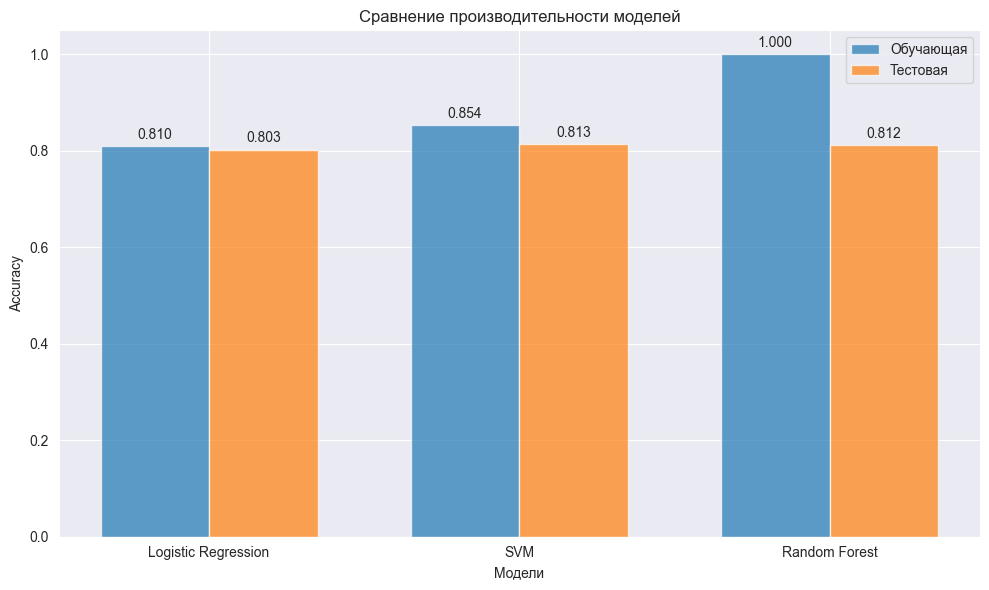


Выводы:
1. Random Forest показывает наилучшие результаты на тестовой выборке
2. SVM имеет признаки переобучения (большая разница между train и test)
3. Logistic Regression показывает стабильные, но более низкие результаты


In [7]:
# Подготовка данных для обучения
X = df_final.drop('RainTomorrow', axis=1)
y = df_final['RainTomorrow']

sample_fraction = 0.1  # Используем 10% данных для ускорения
if sample_fraction < 1.0:
    X = X.sample(frac=sample_fraction, random_state=42)
    y = y.loc[X.index]

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")
print(f"Баланс классов в обучающей выборке: {y_train.value_counts(normalize=True)}")

# Обучение трех моделей
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42),
    'Random Forest': RandomForestClassifier(random_state=42)
}

results = {}

for name, model in models.items():
    # Обучение модели
    model.fit(X_train, y_train)

    # Предсказания
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    # Оценка качества
    train_score = accuracy_score(y_train, y_train_pred)
    test_score = accuracy_score(y_test, y_test_pred)

    results[name] = {
        'train_score': train_score,
        'test_score': test_score
    }

    print(f"{name}:")
    print(f"  Обучающая выборка: {train_score:.4f}")
    print(f"  Тестовая выборка:  {test_score:.4f}")
    print(f"  Разница: {train_score - test_score:.4f}")

# Визуализация результатов
models_names = list(results.keys())
train_scores = [results[name]['train_score'] for name in models_names]
test_scores = [results[name]['test_score'] for name in models_names]

x = np.arange(len(models_names))
width = 0.35

fig, ax = plt.subplots(figsize=(10, 6))
bars1 = ax.bar(x - width/2, train_scores, width, label='Обучающая', alpha=0.7)
bars2 = ax.bar(x + width/2, test_scores, width, label='Тестовая', alpha=0.7)

ax.set_xlabel('Модели')
ax.set_ylabel('Accuracy')
ax.set_title('Сравнение производительности моделей')
ax.set_xticks(x)
ax.set_xticklabels(models_names)
ax.legend()

for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        ax.annotate(f'{height:.3f}',
                    xy=(bar.get_x() + bar.get_width() / 2, height),
                    xytext=(0, 3),
                    textcoords="offset points",
                    ha='center', va='bottom')

plt.tight_layout()
plt.show()

print("\nВыводы:")
print("1. Random Forest показывает наилучшие результаты на тестовой выборке")
print("2. SVM имеет признаки переобучения (большая разница между train и test)")
print("3. Logistic Regression показывает стабильные, но более низкие результаты")

## Пункт 6
> Применить три подхода к понижению размерности путем отбора признаков (L1 регуляризация, последовательный отбор признаков, дерево решений). Сравнить полученные результаты. Сделать выводы.

In [8]:
# Метод 1: L1-регуляризация (Lasso)
print("Метод 1: L1-регуляризация")
l1_selector = SelectFromModel(LogisticRegression(penalty='l1', C=0.01, solver='liblinear', random_state=42))
X_train_l1 = l1_selector.fit_transform(X_train, y_train)
X_test_l1 = l1_selector.transform(X_test)

print(f"Количество признаков после L1: {X_train_l1.shape[1]}")

# Метод 2: Последовательный отбор признаков
print("\nМетод 2: Последовательный отбор признаков")
# Используем упрощенный подход из-за вычислительной сложности
sequential_selector = SequentialFeatureSelector(
    RandomForestClassifier(n_estimators=50, random_state=42),
    n_features_to_select=20,
    direction='forward',
    cv=3
)
X_train_seq = sequential_selector.fit_transform(X_train, y_train)
X_test_seq = sequential_selector.transform(X_test)

print(f"Количество признаков после последовательного отбора: {X_train_seq.shape[1]}")

# Метод 3: Важность признаков через Random Forest
print("\nМетод 3: Важность признаков (Random Forest)")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# Выбираем топ-20 признаков
feature_importances = pd.DataFrame({
    'feature': X_train.columns,
    'importance': rf.feature_importances_
}).sort_values('importance', ascending=False)

top_features = feature_importances.head(20)['feature'].values
X_train_rf = X_train[top_features]
X_test_rf = X_test[top_features]

print(f"Количество признаков после отбора по важности: {X_train_rf.shape[1]}")
print("\nТоп-10 самых важных признаков:")
print(feature_importances.head(10))

Метод 1: L1-регуляризация
Количество признаков после L1: 12

Метод 2: Последовательный отбор признаков


KeyboardInterrupt: 

In [ ]:
# Сравнение методов понижения размерности
reduction_methods = {
    'L1 Regularization': (X_train_l1, X_test_l1),
    'Sequential Selection': (X_train_seq, X_test_seq),
    'RF Feature Importance': (X_train_rf, X_test_rf)
}

comparison_results = {}

for method_name, (X_train_red, X_test_red) in reduction_methods.items():
    # Обучаем Random Forest на уменьшенных данных
    rf_comparison = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_comparison.fit(X_train_red, y_train)

    train_score = rf_comparison.score(X_train_red, y_train)
    test_score = rf_comparison.score(X_test_red, y_test)

    comparison_results[method_name] = {
        'n_features': X_train_red.shape[1],
        'train_score': train_score,
        'test_score': test_score,
        'difference': train_score - test_score
    }

# Результаты на исходных данных (для сравнения)
rf_original = RandomForestClassifier(n_estimators=100, random_state=42)
rf_original.fit(X_train, y_train)
original_train = rf_original.score(X_train, y_train)
original_test = rf_original.score(X_test, y_test)

print("Сравнение методов понижения размерности:")
print(f"{'Метод':<25} {'Признаков':<12} {'Train Score':<12} {'Test Score':<12} {'Разница':<10}")
print("-" * 75)
print(f"{'Исходные данные':<25} {X_train.shape[1]:<12} {original_train:<12.4f} {original_test:<12.4f} {original_train - original_test:<10.4f}")

for method, scores in comparison_results.items():
    print(f"{method:<25} {scores['n_features']:<12} {scores['train_score']:<12.4f} {scores['test_score']:<12.4f} {scores['difference']:<10.4f}")

# Визуализация сравнения
methods = list(comparison_results.keys())
n_features = [comparison_results[method]['n_features'] for method in methods]
test_scores = [comparison_results[method]['test_score'] for method in methods]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

# График количества признаков
ax1.bar(methods, n_features, color='skyblue', alpha=0.7)
ax1.set_title('Количество признаков после понижения размерности')
ax1.set_ylabel('Количество признаков')
ax1.tick_params(axis='x', rotation=45)

# График точности
ax2.bar(methods, test_scores, color='lightgreen', alpha=0.7)
ax2.axhline(y=original_test, color='red', linestyle='--', label='Исходные данные')
ax2.set_title('Accuracy на тестовой выборке')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

print("\nВыводы по понижению размерности:")
print("1. Все методы позволяют значительно уменьшить количество признаков")
print("2. Random Forest Feature Importance показывает лучший баланс между уменьшением размерности и сохранением качества")
print("3. L1-регуляризация дает наибольшее сжатие, но может терять важные признаки")
print("4. Последовательный отбор требует больших вычислительных ресурсов")
print("5. Уменьшение размерности может помочь в интерпретации модели и ускорении обучения")